In [1]:
#!pip install nibabel


In [2]:

import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology as mp
from skimage import measure

In [3]:
path0= "/Users/yoonhonam/Desktop/glioma_segmentation_results/"
pids = os.listdir(path0)
pids

['.DS_Store', 'R0000328', 'R0000317', 'R0000322', 'R0000325']

R0000328
size of t2 image =  (240, 240, 155)
size of msk image =  (240, 240, 155)


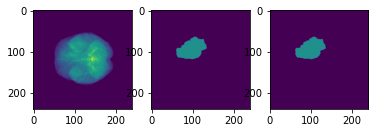

slice # of largest mask: 104


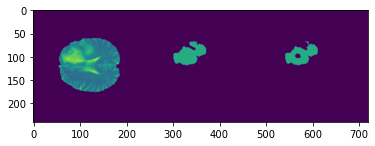

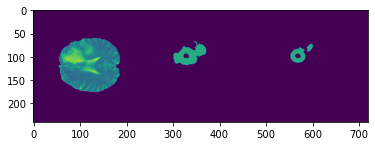

R0000317
size of t2 image =  (240, 240, 155)
size of msk image =  (240, 240, 155)


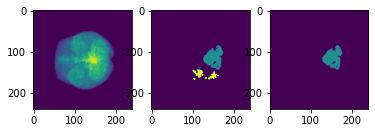

slice # of largest mask: 47


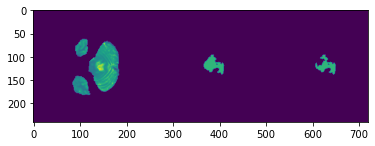

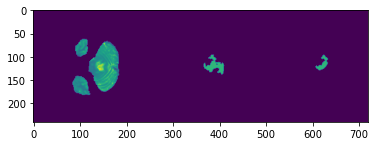

R0000322
size of t2 image =  (240, 240, 155)
size of msk image =  (240, 240, 155)


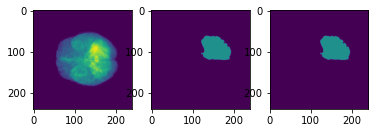

slice # of largest mask: 96


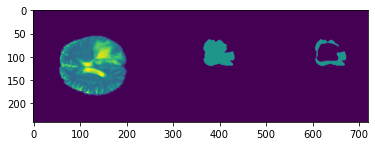

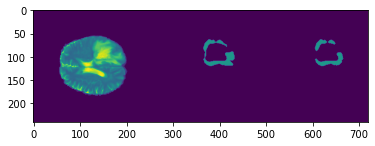

R0000325
size of t2 image =  (240, 240, 155)
size of msk image =  (240, 240, 155)


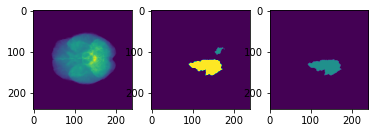

slice # of largest mask: 115


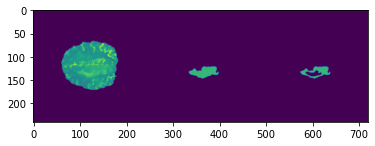

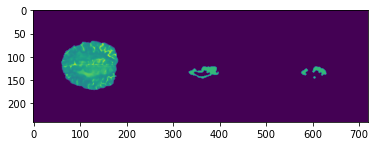

In [4]:
imgname = "data_t2.nii.gz"
segname_new = "net_mask_new.nii.gz"     # filename of processed mask

# factor
Ne_val = 2
Nd_val = 10

thres_edm_vol = 100 # (100 mm^3)

for i in range(0,len(pids)):
    if os.path.isdir(path0+pids[i]):
        print(pids[i])
        pid = pids[i]

        path = path0+pid
        segname = "net_input_"+pid+".nii.gz"    # filename of input mask

        t2 = nib.load(path+'/'+imgname)
        edm = nib.load(path+'/'+segname)

        vs = t2.header.get_zooms()
        Ne = (np.round(Ne_val/vs[0])).astype(int) # 3mm 
        Nd = (np.round(Nd_val/vs[0])).astype(int) # distance

        t2img = t2.get_fdata()
        t2img = (t2img-np.min(t2img))/(np.max(t2img)-np.min(t2img))
        print('size of t2 image = ',t2img.shape)
        edmimg = edm.get_fdata()
        print('size of msk image = ',edmimg.shape)
        totalimg = edm.get_fdata()
        totalimg = (totalimg>0).astype(int)
        edmimg = (edmimg==2).astype(int)

        labels = measure.label(totalimg)

        if np.max(labels)>0:
            labels_vol=np.zeros((np.max(labels)+1,1))
            for ll in range(0,np.max(labels)+1):
                if ll == 0:
                    labels_vol[ll]=0
                else:
                    labels_vol[ll] = np.sum(labels==ll)
            labels_th = np.argmax(labels_vol)
        else:
            labels_th = 1


        totalimg[labels!=labels_th]=0
        edmimg[labels!=labels_th]=0
        plt.subplot(1,3,1)
        plt.imshow(np.mean(t2img,axis=2))
        plt.subplot(1,3,2)
        plt.imshow(np.amax(labels,axis=2),vmin=0,vmax=2)
        plt.subplot(1,3,3)
        plt.imshow(np.amax(totalimg,axis=2),vmin=0,vmax=2)
        plt.show()

        zzz=np.sum(np.sum(edmimg,axis=1),axis=0)
        zmax=np.argmax(zzz)
        print('slice # of largest mask:',zmax)
        n_slice = zmax # slice number to be displayed
        plt.imshow(np.concatenate((t2img[:,:,n_slice]*2,totalimg[:,:,n_slice],edmimg[:,:,n_slice]),axis=1))
        plt.show()


        if np.sum(zzz)*(np.prod(vs))>thres_edm_vol:
            NX,NY,NZ=edmimg.shape
            NZ
            edmimg_new=np.zeros(edmimg.shape)
            # for 2d erosion/dilation (for conventional 2D MR images)
            for nz in range(NZ):
                mass = (totalimg[:,:,nz]-edmimg[:,:,nz])>0.5
                mass = mp.binary_opening(mass,selem=mp.disk(Ne))
                edema = edmimg[:,:,nz]>0.5
                edmimg_new[:,:,nz]=mp.binary_opening(np.multiply(mp.binary_dilation(mass,selem=mp.disk(Nd)),edema),selem=mp.disk(Ne))
            n_slice = zmax # slice number to be displayed
            plt.imshow(np.concatenate((t2img[:,:,n_slice]*2,edmimg[:,:,n_slice],edmimg_new[:,:,n_slice]),axis=1))
            plt.show()
            edmimg_new = ((edmimg_new.astype(int))>0.5).astype(int)
            edm_new=nib.Nifti1Image(edmimg_new,edm.affine,edm.header)
            nib.save(edm_new,path+'/'+segname_new)
        else:
            disp('skipped: edema volume is zero or too small')

